# About Dataset

The dataset contains EEG signals from 11 subjects with labels of alert and drowsy. It can be opened with Matlab. We extracted the data for our own research purpose from another public dataset:

Cao, Z., et al., Multi-channel EEG recordings during a sustained-attention driving task. Scientific data, 2019. 6(1): p. 1-8.

If you find the dataset useful, please give credits to their works.

The details on how the data were extracted are described in our paper:

"Jian Cui, Zirui Lan, Yisi Liu, Ruilin Li, Fan Li, Olga Sourina, Wolfgang MÃ¼ller-Wittig, A Compact and Interpretable Convolutional Neural Network for Cross-Subject Driver Drowsiness Detection from Single-Channel EEG, Methods, 2021, ISSN 1046-2023, https://doi.org/10.1016/j.ymeth.2021.04.017."

The codes of the paper above are accessible from:

https://github.com/cuijiancorbin/A-Compact-and-Interpretable-Convolutional-Neural-Network-for-Single-Channel-EEG

The data file contains 3 variables and they are EEGsample, substate and subindex.

"EEGsample" contains 2022 EEG samples of size 20x384 from 11 subjects. Each sample is a 3s EEG data with 128Hz from 30 EEG channels.
"subindex" is an array of 2022x1. It contains the subject indexes from 1-11 corresponding to each EEG sample.
"substate" is an array of 2022x1. It contains the labels of the samples. 0 corresponds to the alert state and 1 correspond to the drowsy state.

The unbalanced version of this dataset is accessible from:
https://figshare.com/articles/dataset/EEG_driver_drowsiness_dataset_unbalanced_/16586957

# Reference: Siamese Networks - Few Shot Learning

https://github.com/akshaysharma096/Siamese-Networks/blob/master/Few%20Shot%20Learning%20-%20V1.ipynb

https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d

https://neptune.ai/blog/understanding-few-shot-learning-in-computer-vision

# Siamese Networks

Siamese network is a Deep Nueral Network architecture proposed by Gregory et. al in his paper Siamese Neural Networks for One-shot Image Recognition, the paper proposes an architecture where using Convolutional Nueral Networks one can tackle the problem of One Shot Learning.

The model aims to solve the basic problem of image verification, given that we have very few samples of image of each class or category

The models aims to learn the embeddings of 2 separate images fed into the Nueral Network, the two embeddings are used to calculate the L1 distance between the 2 embeddings. Once the distance embedding metric is calculated, the embedding is fed into a sigmoid unit which by the magic of back propogation, learns the correct set of hyperparameters to carry out the image verification.

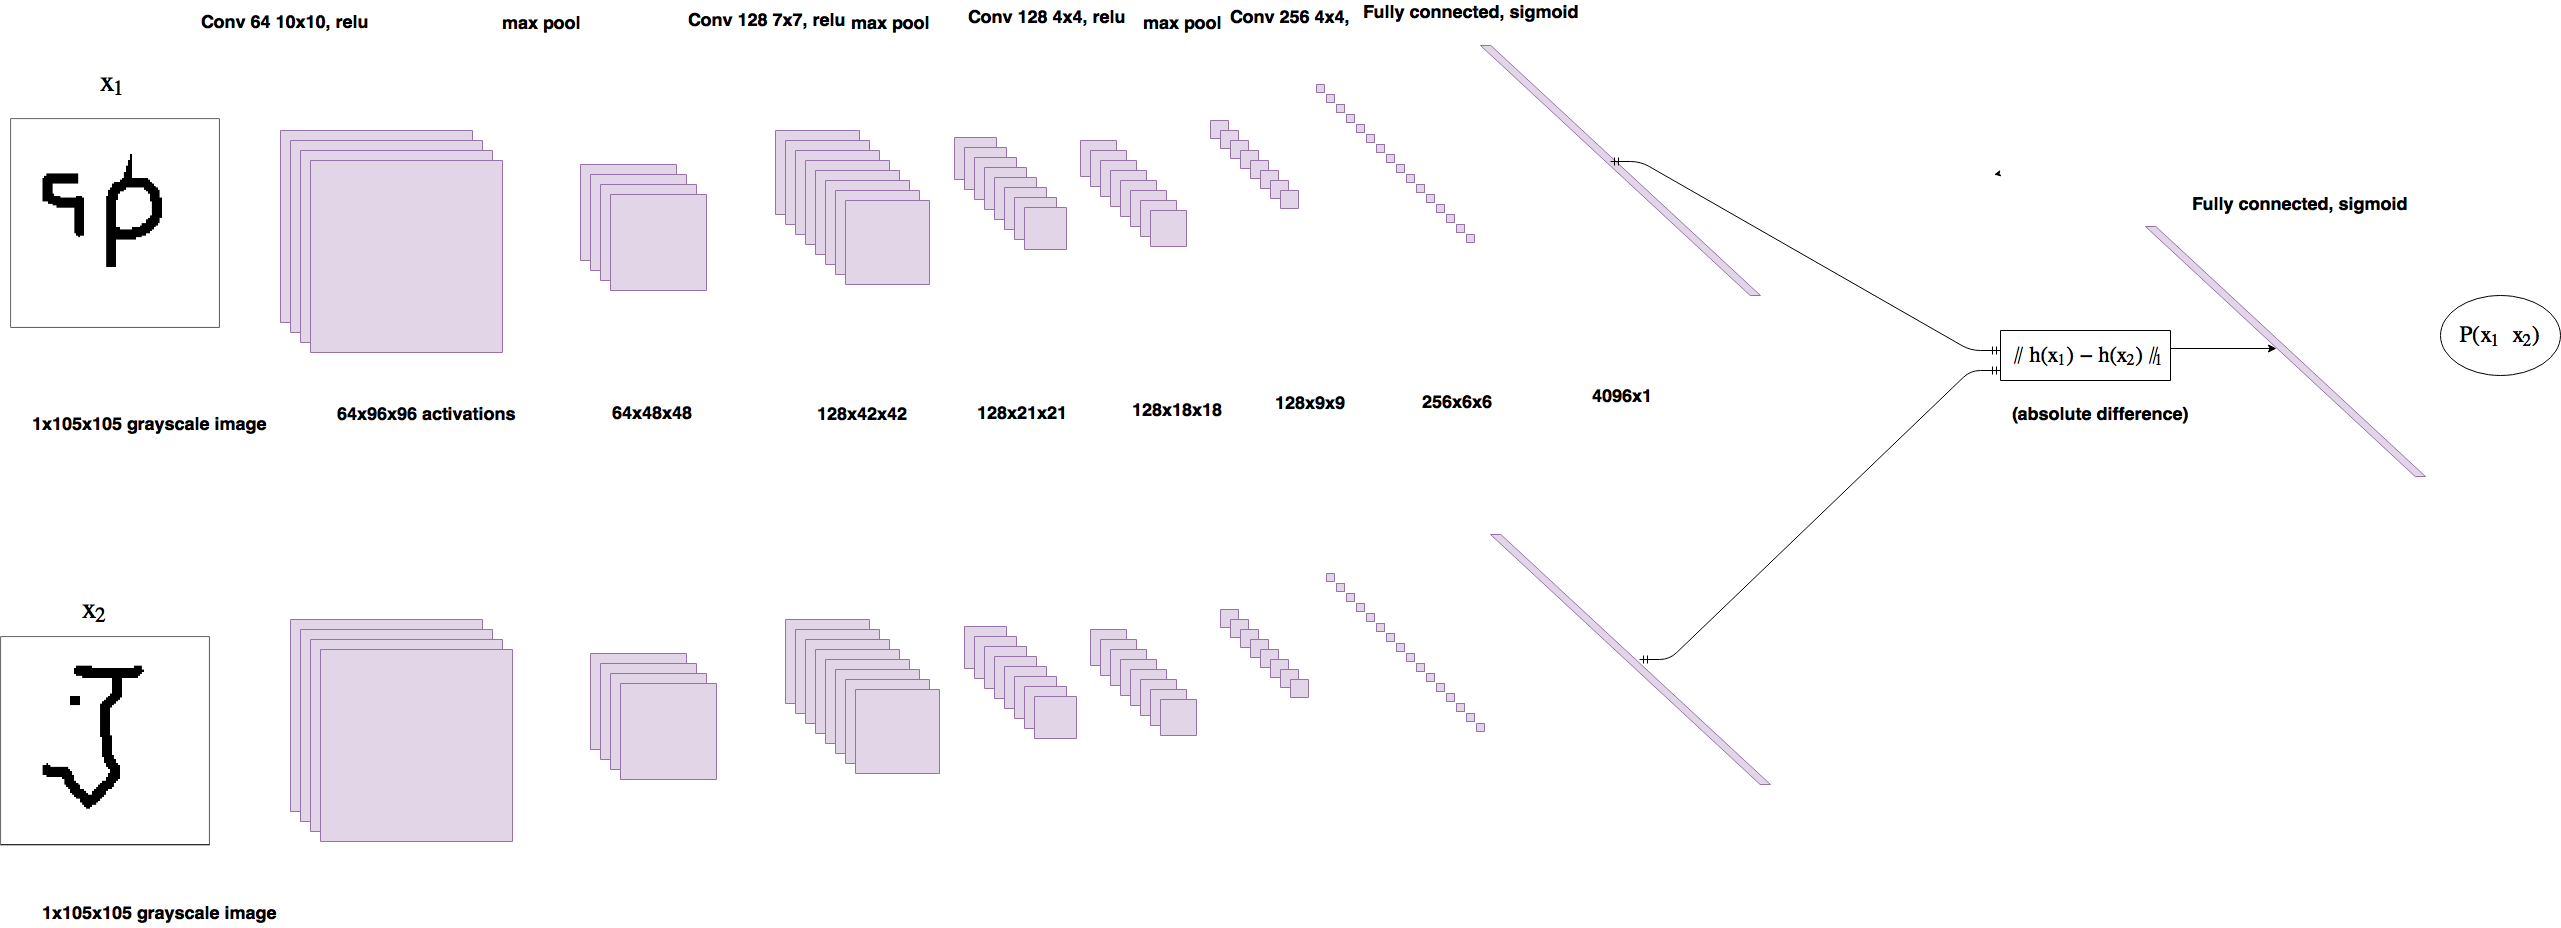

In [1]:
from IPython.display import Image, display

image_path = 'Image - Siamese Networks.png'
display(Image(filename=image_path))

The model of Siamese network can be described as CNN architecture with 2 arms, a right arm and a left arm. The CNN architecture of a single arm has 9 layers, including Max Pooling and Convolutional layers of different filter sizes, as described in the paper. These 9 layers work as feature selectors for the CNN architecture. Convolutional layers are initialized with weights having 0 mean 0.01 standard deviation, also the bias hyperparameter of the these layers is initialized with a mean value of 0.5 and a standard deviation of 0.01.

The basic intuition that once can gain from the paper is that it uses the L1 distance between the pixels of 2 different images as a metric of similarity.

If 2 images are similar the L1 distance between them will be lower as compared to the L1 distance computed for 2 somewhat different images.
The L1 distance computed is then used to train the sigmoid unit to find the write set of hyperparameters.

#  Importing Necessary Libraries

In [2]:
import numpy as np
import os
import pickle
import time
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv1D, Flatten, Dense, Lambda
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
from numpy.random import randint

#  Loading Data

In [3]:
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(621158, 5)
(621158,)
(155290, 5)
(155290,)


#  Model Architecture

In [ ]:
def initialize_weights(shape, dtype=None):
    return RandomNormal(mean=0.0, stddev=0.01, seed=None)(shape, dtype=dtype)

def initialize_bias(shape, dtype=None):
    return RandomNormal(mean=0.5, stddev=0.01, seed=None)(shape, dtype=dtype)

def get_siamese_model(input_shape):
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    model = Sequential()
    model.add(Conv1D(64, 2, activation='relu', input_shape=input_shape,
                     kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(Conv1D(128, 2, activation='relu',
                     kernel_initializer=initialize_weights, bias_initializer=initialize_bias,
                     kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                    kernel_regularizer=l2(1e-3), kernel_initializer=initialize_weights,
                    bias_initializer=initialize_bias))
    
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1, activation='sigmoid', bias_initializer=initialize_bias)(L1_distance)
    
    siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)
    return siamese_net

input_shape = (5, 1)
model = get_siamese_model(input_shape)
model.summary()

In [ ]:
from tensorflow import keras

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="binary_crossentropy", optimizer=optimizer)

# Data Loader Class

In [ ]:
class Siamese_Loader:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
    
    def get_batch(self, batch_size, s="train"):
        X = self.X_train if s == "train" else self.X_test
        y = self.y_train if s == "train" else self.y_test
        
        pairs = [np.zeros((batch_size, X.shape[1], 1)) for _ in range(2)]
        targets = np.zeros((batch_size,))
        targets[batch_size // 2:] = 1
        
        for i in range(batch_size):
            idx1 = randint(0, len(X))
            pairs[0][i, :, 0] = X[idx1]
            if i >= batch_size // 2:
                idx2 = np.where(y == y[idx1])[0][randint(0, np.sum(y == y[idx1]))]
            else:
                idx2 = np.where(y != y[idx1])[0][randint(0, np.sum(y != y[idx1]))]
            pairs[1][i, :, 0] = X[idx2]
        
        return pairs, targets
    
    def generate(self, batch_size, s="train"):
        while True:
            pairs, targets = self.get_batch(batch_size, s)
            yield pairs, targets
    
    def make_oneshot_task(self, N, s="val"):
        X = self.X_test if s == "val" else self.X_train
        y = self.y_test if s == "val" else self.y_train
        
        true_category = randint(0, len(X))
        indices = randint(0, len(X), size=(N,))
        
        test_image = np.asarray([X[true_category]] * N).reshape(N, X.shape[1], 1)
        support_set = X[indices].reshape(N, X.shape[1], 1)
        
        targets = np.zeros((N,))
        targets[0] = 1
        
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image, support_set]
        return pairs, targets
    
    def test_oneshot(self, model, N, k, s="val", verbose=0):
        n_correct = 0
        for _ in range(k):
            pairs, targets = self.make_oneshot_task(N, s)
            probs = model.predict(pairs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct += 1
        return 100.0 * n_correct / k

loader = Siamese_Loader(X_train, y_train, X_test, y_test)


#  Training the Model

In [ ]:
evaluate_every = 10
loss_every = 20
batch_size = 32
n_iter = 20000
N_way = 20
n_val = 250
best = -1

print("Starting training process!")
print("-------------------------------------")
t_start = time.time()

for i in range(1, n_iter + 1):
    inputs, targets = loader.get_batch(batch_size)
    loss = model.train_on_batch(inputs, targets)
    print(f"Iteration {i}/{n_iter}, Loss: {loss:.4f}")
    
    if i % evaluate_every == 0:
        print(f"Time for {i} iterations: {time.time() - t_start:.2f} seconds")
        val_acc = loader.test_oneshot(model, N_way, n_val, s="val", verbose=True)
        if val_acc >= best:
            print(f"Current best: {val_acc:.2f}%, Previous best: {best:.2f}%")
            model.save_weights('best_weights.h5')
            best = val_acc
    
    if i % loss_every == 0:
        print(f"Iteration {i}, training loss: {loss:.4f}")

model.load_weights('best_weights.h5')


# Evaluating the Model

In [ ]:
def nearest_neighbour_correct(pairs, targets):
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(np.sum((pairs[0][i] - pairs[1][i]) ** 2)))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

def test_nn_accuracy(N_ways, n_trials, loader):
    print(f"Evaluating nearest neighbour on {n_trials} unique {N_ways}-way one-shot learning tasks ...")
    n_right = 0
    for _ in range(n_trials):
        pairs, targets = loader.make_oneshot_task(N_ways, "val")
        correct = nearest_neighbour_correct(pairs, targets)
        n_right += correct
    return 100.0 * n_right / n_trials

ways = np.arange(1, 30, 2)
val_accs, train_accs, nn_accs = [], [], []
trials = 450

for N in ways:
    val_accs.append(loader.test_oneshot(model, N, trials, "val", verbose=True))
    train_accs.append(loader.test_oneshot(model, N, trials, "train", verbose=True))
    nn_accs.append(test_nn_accuracy(N, trials, loader))

plt.plot(ways, val_accs, "m", label='Validation Accuracy')
plt.plot(ways, train_accs, "y", label='Training Accuracy')
plt.plot(ways, nn_accs, "c", label='NN Accuracy')
plt.plot(ways, 100.0 / ways, "r", label='Random Chance')
plt.legend()
plt.show()
